Zadanie 2. Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}


*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm*
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def min_max_norm(val, min_val, max_val, new_min, new_max):
    return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min


def bin_vect_to_decimal(bin_vector):
    decimal = 0
    bit_value = 1
    for bit in bin_vector:
        decimal += bit_value*bit
        bit_value *= 2
    return decimal


def function(x):
    return 1.5 - np.exp(-x[0] ** (2) - x[1] ** (2)) - 0.5 * np.exp(-(x[0] - 1) ** (2) - (x[1] + 2) ** (2))

In [3]:
class Chromosome:
    def __init__(self, length, array=None):
        self.length = length
        self.array = array
        if not array:
            self.array = random.choices([0, 1], k=length)

    def decode(self, lower_bound, upper_bound, aoi):
        val = bin_vect_to_decimal(self.array[lower_bound:upper_bound])
        max_value = 2**(upper_bound - lower_bound) - 1
        return min_max_norm(val, 0, max_value, aoi[0], aoi[1])

    def mutation(self, probability):
        if random.random() <= probability:
            iter = random.randint(0, self.length-1)
            self.array[iter] = int(not self.array[iter])
        return 0

    def crossover(self, other):
        cross_point = random.randint(1, self.length-1)
        child1 = Chromosome(self.length, self.array[0:cross_point] + other.array[cross_point:self.length])
        child2 = Chromosome(self.length, other.array[0:cross_point] + self.array[cross_point:self.length])
        return random.choice([child1, child2])



*   Metoda *decode* - oblicza wartość wybranego fragmentu chromosomu i zamienia go na wartość z podanego przedziału *aoi*
*   Metoda *mutation* - wybiera losowo jeden gen i zmienia jego wartość. Zmiana zachodzi pod podanym prawdopodobieństwem
*   Metoda *crossover* - implementuje krzyżowanie jednopunktowe polegające na wybraniu losowego potomka, który powstaje po stworzeniu z fragmentów rodziców, także wybranych losowo



In [5]:
class GeneticAlgorithm:
    def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000, tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
        assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
        self.chromosome_lengths = chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function
        self.aoi = aoi
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps
        self.population_size = population_size
        self.chromosomes = [Chromosome(chromosome_length) for i in range(population_size)]
        self.trace = []

    def eval_objective_func(self, chromosome: Chromosome):
        function_args = [chromosome.decode(lower_bound=i, upper_bound=i+self.bits_per_arg, aoi=self.aoi) for i in range(0, chromosome.length, self.bits_per_arg)]
        eval = self.objective_function(function_args)
        return eval

    def mutate(self):
        for chromosome in self.chromosomes:
            chromosome.mutation(self.mutation_probability)
        return 0

    def tournament_selection(self):
        chosen_ones = []
        for i in range(self.population_size):
            fighters = random.sample(self.chromosomes, self.tournament_size)
            winner = min(fighters, key=self.eval_objective_func)
            chosen_ones.append(winner)
        return chosen_ones

    def reproduce(self, parents):
        new_population = []
        while (len(new_population) < self.population_size):
            parent1, parent2 = random.sample(parents, 2)
            if random.random() < self.crossover_probability:
                new_population.append(parent1.crossover(parent2))
            else:
                new_population.append(random.choice([parent1, parent2]))
        self.chromosomes = new_population
        return 0

    def plot_func(self):
        X = np.arange(-4, 4, 0.005)
        Y = np.arange(-4, 4, 0.005)
        X, Y = np.meshgrid(X, Y)
        #Z = X**2 + Y**2
        Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
        plt.figure()
        plt.contour(X, Y, Z, 10)
        cmaps = [[ii / len(self.trace), 0, 0] for ii in range(len(self.trace))]
        plt.scatter([x[0] for x in self.trace], [x[1] for x in self.trace], c=cmaps)
        plt.show()

    def run(self):
        for i in range(self.num_steps):
            self.mutate()
            self.reproduce(self.tournament_selection())
            best = min(self.chromosomes, key=self.eval_objective_func)
            trace_arguments = [best.decode(lower_bound=i, upper_bound=i+self.bits_per_arg, aoi=self.aoi) for i in range(0, best.length, self.bits_per_arg)]
            self.trace.append(trace_arguments)
        return 0

* Metoda *eval_objective_func* - oblicza wartość funcji celu dla współrzędnych punktu, których wartość zawarta jest w podanym chromosomie
* Metoda *mutate* - dla każdego chromosomu z kolekcji wykonuje metodę *mutation* o podanym prawdopodobieństwie
* Metoda *tournament_selection* - przeprowadza ilość pojedynków równą rozmiarowi populacji. Pojedynki są przeprowadzane między wskazaną liczbą chromosomów wybieranych losowo za każdym razem. Zwycięzcą każdego pojedynku jest chromosom, którego wartość dla funkcji celu jest najmniejsza.
* Metoda *reproduce* - tworzy nową populację poprzez metodę *crossover* wołaną dla dwóch chromosomów losowanych za każdym razem. Jeżeli nie uda się wywołać metody *crossover*, do nowej populacji trafia losowy rodzic.
* Metoda *plot_function* - tworzy wykres funkcji, na którym zaznaczone są najlepsze osobniki z każdej generacji
* Metoda *run* - odpowiada za wykonanie algorytmu genetycznego przez określoną liczbę generacji. Wykorzystuje do tego metody *mutate*, *reproduce* oraz *turnament_selection*. Zapisuje także najlepszego osobnika z danej generacji.

chromosome_length = 1024, population_size = 500, mutation_probability = 0.8, number_of_steps = 100


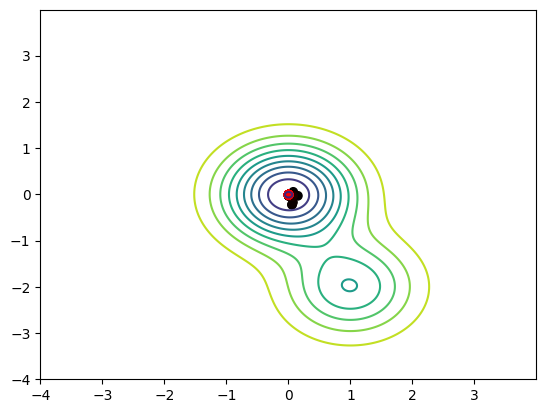


chromosome_length = 1024, population_size = 500, mutation_probability = 0.5, number_of_steps = 100


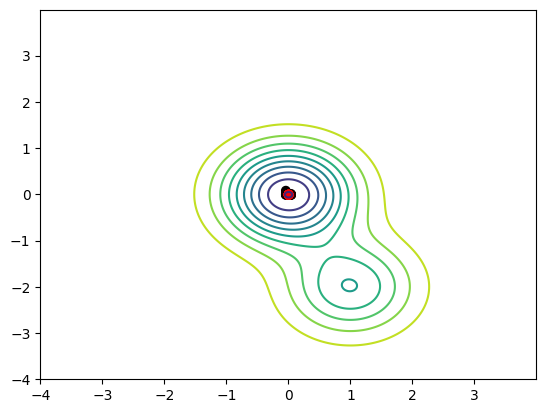


chromosome_length = 1024, population_size = 500, mutation_probability = 0.1, number_of_steps = 100


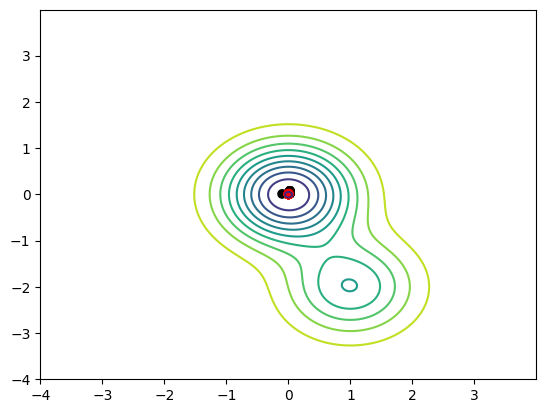


chromosome_length = 1024, population_size = 100, mutation_probability = 0.8, number_of_steps = 100


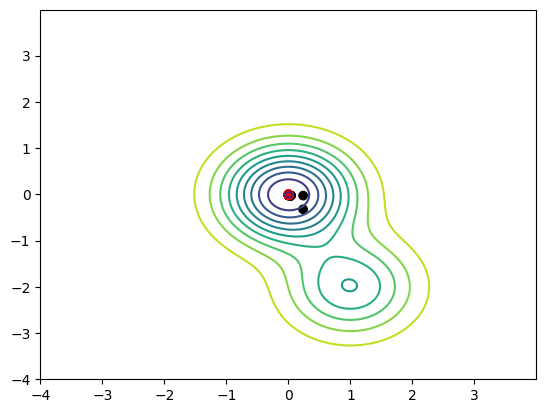


chromosome_length = 1024, population_size = 100, mutation_probability = 0.5, number_of_steps = 100


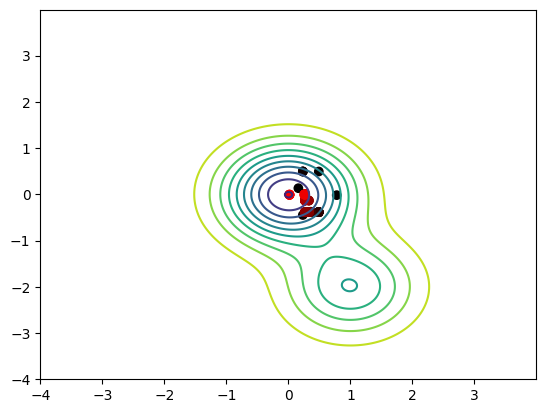


chromosome_length = 1024, population_size = 100, mutation_probability = 0.1, number_of_steps = 100


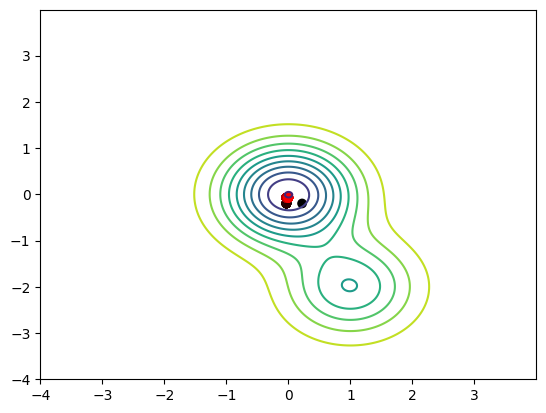


chromosome_length = 1024, population_size = 10, mutation_probability = 0.8, number_of_steps = 100


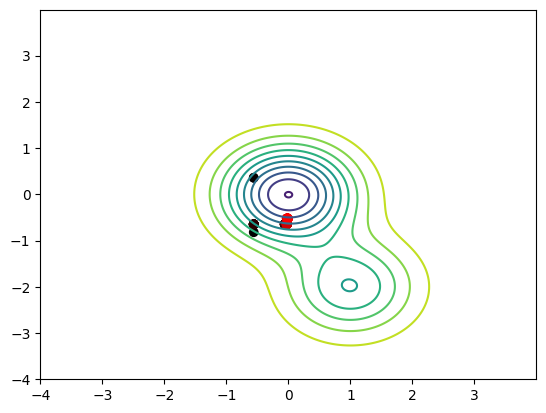


chromosome_length = 1024, population_size = 10, mutation_probability = 0.5, number_of_steps = 100


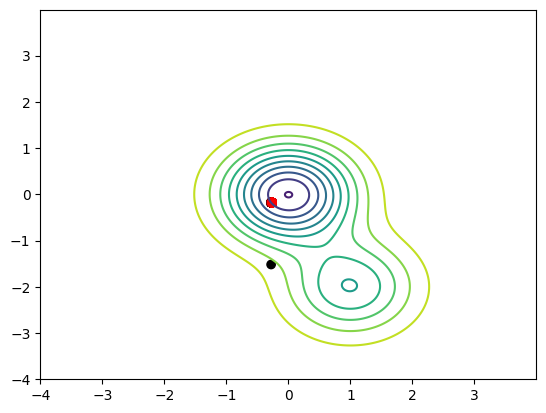


chromosome_length = 1024, population_size = 10, mutation_probability = 0.1, number_of_steps = 100


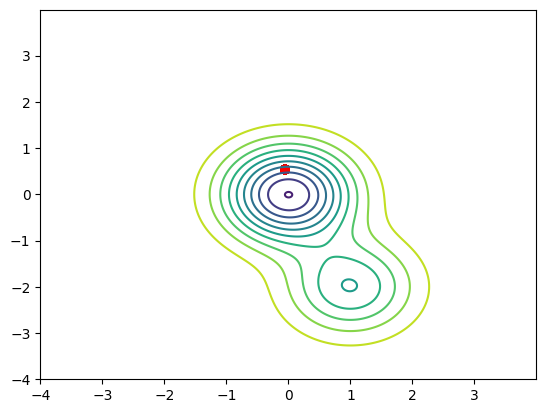


chromosome_length = 512, population_size = 500, mutation_probability = 0.8, number_of_steps = 100


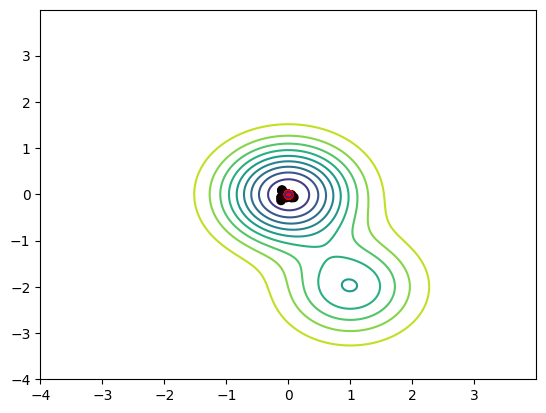


chromosome_length = 512, population_size = 500, mutation_probability = 0.5, number_of_steps = 100


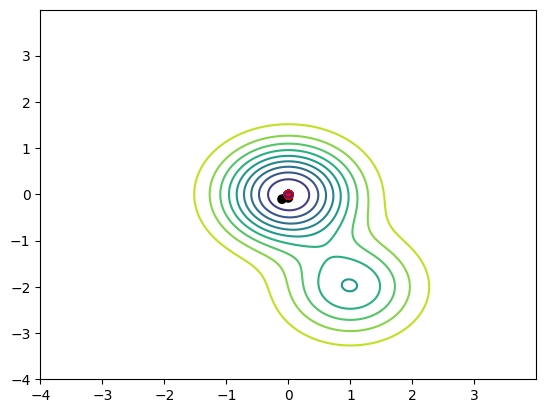


chromosome_length = 512, population_size = 500, mutation_probability = 0.1, number_of_steps = 100


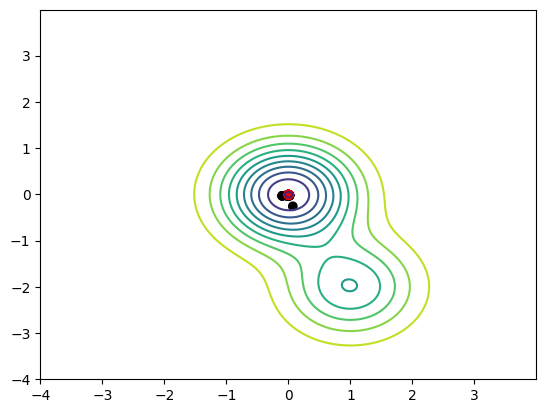


chromosome_length = 512, population_size = 100, mutation_probability = 0.8, number_of_steps = 100


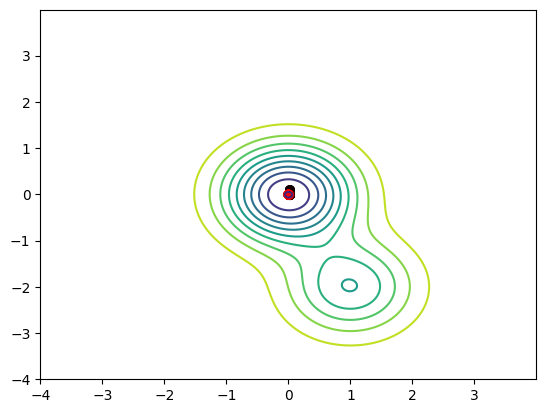


chromosome_length = 512, population_size = 100, mutation_probability = 0.5, number_of_steps = 100


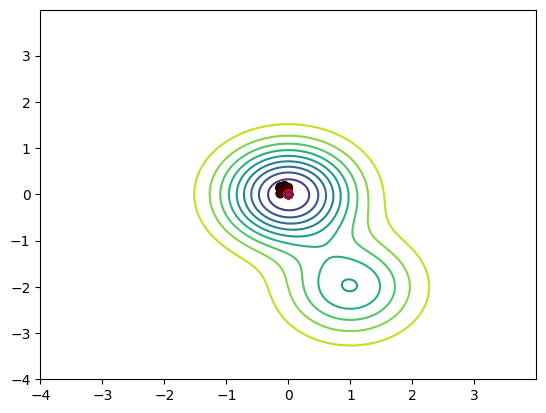


chromosome_length = 512, population_size = 100, mutation_probability = 0.1, number_of_steps = 100


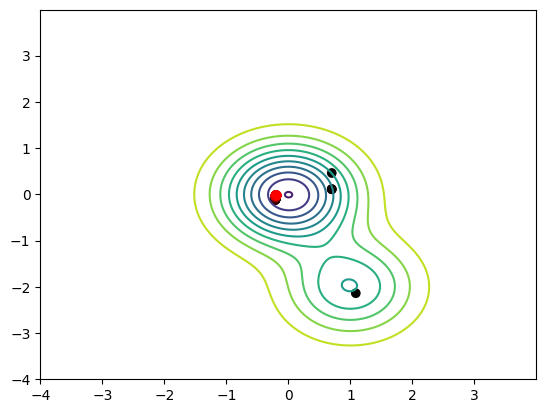


chromosome_length = 512, population_size = 10, mutation_probability = 0.8, number_of_steps = 100


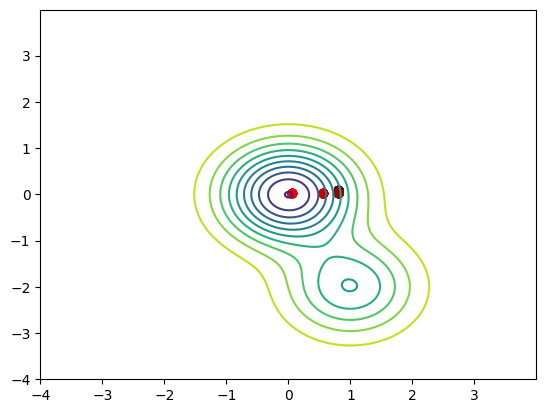


chromosome_length = 512, population_size = 10, mutation_probability = 0.5, number_of_steps = 100


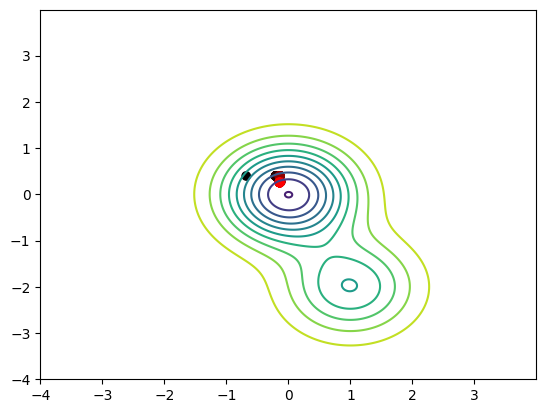


chromosome_length = 512, population_size = 10, mutation_probability = 0.1, number_of_steps = 100


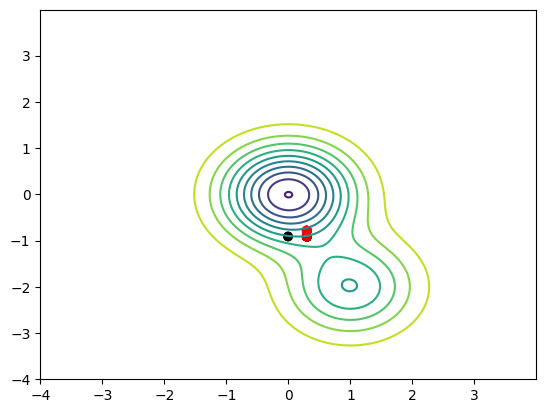


chromosome_length = 16, population_size = 500, mutation_probability = 0.8, number_of_steps = 100


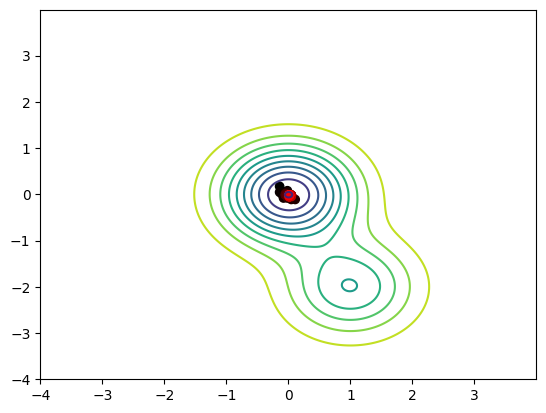


chromosome_length = 16, population_size = 500, mutation_probability = 0.5, number_of_steps = 100


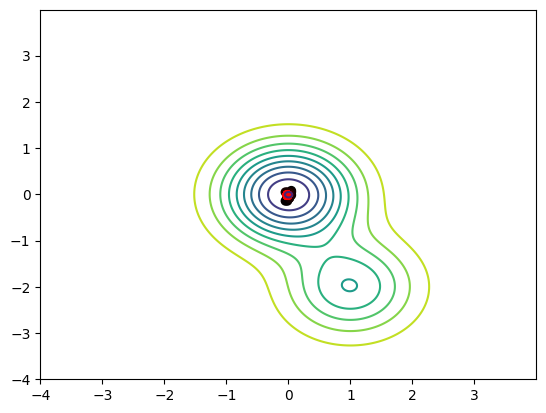


chromosome_length = 16, population_size = 500, mutation_probability = 0.1, number_of_steps = 100


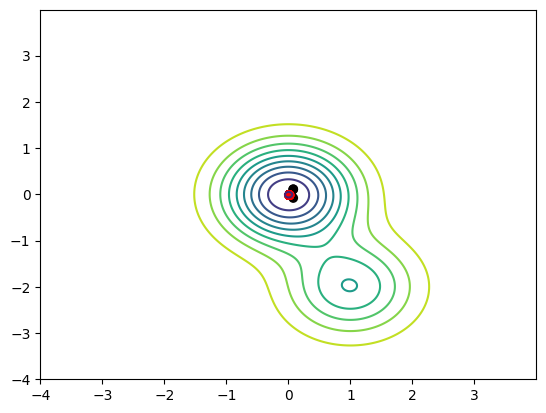


chromosome_length = 16, population_size = 100, mutation_probability = 0.8, number_of_steps = 100


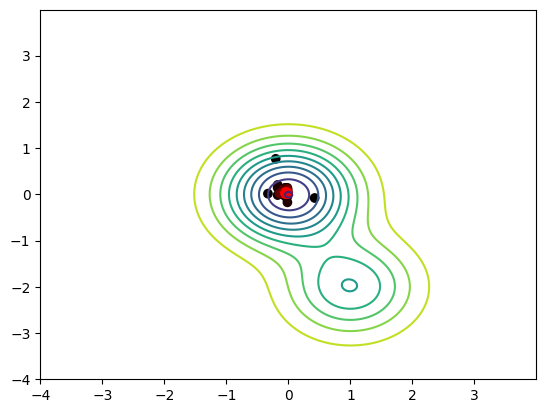


chromosome_length = 16, population_size = 100, mutation_probability = 0.5, number_of_steps = 100


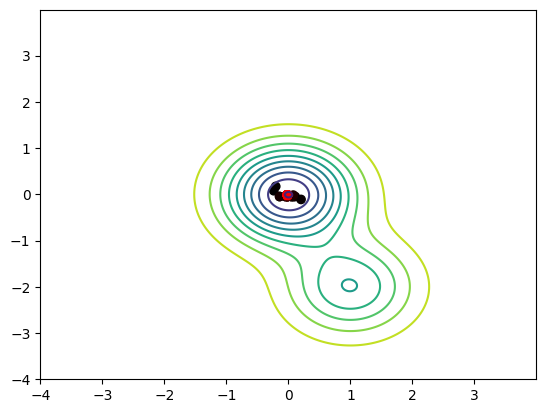


chromosome_length = 16, population_size = 100, mutation_probability = 0.1, number_of_steps = 100


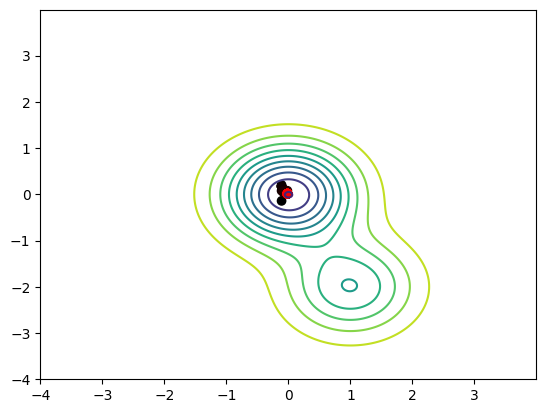


chromosome_length = 16, population_size = 10, mutation_probability = 0.8, number_of_steps = 100


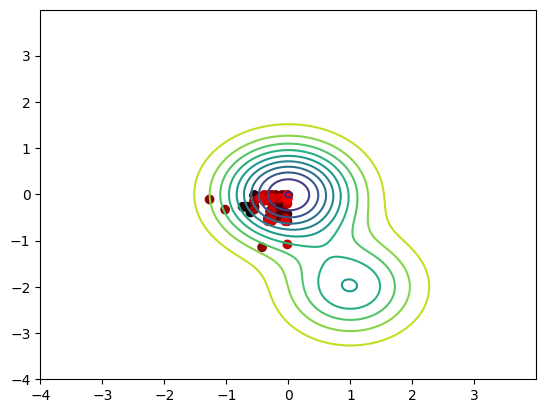


chromosome_length = 16, population_size = 10, mutation_probability = 0.5, number_of_steps = 100


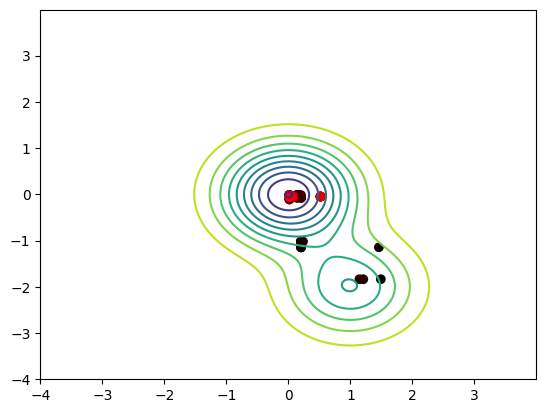


chromosome_length = 16, population_size = 10, mutation_probability = 0.1, number_of_steps = 100


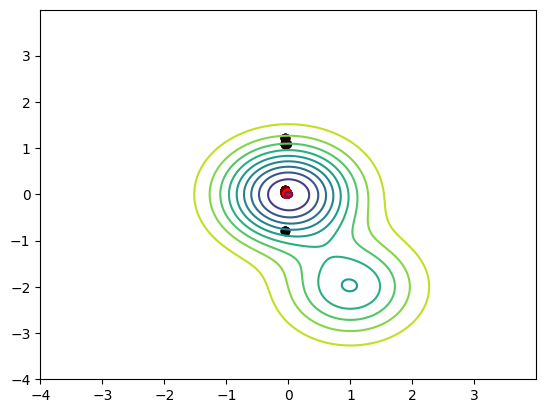

In [13]:
chromosome_lengths = [1024, 512, 16]
population_sizes = [500, 100, 10]
mutation_probabilities = [0.8, 0.5, 0.1]

for chromosome_length in chromosome_lengths:
    for population_size in population_sizes:
        for mutation_probability in mutation_probabilities:
            obj_func_num_args = 2
            objective_function = function
            aoi = [-4, 4]
            tournament_size = 2
            crossover_probability = 0.8
            num_steps = 100
            print(f"chromosome_length = {chromosome_length}, population_size = {population_size}, mutation_probability = {mutation_probability}, number_of_steps = {num_steps}")
            algorithm = GeneticAlgorithm(chromosome_length, obj_func_num_args, objective_function, aoi, population_size, tournament_size, mutation_probability, crossover_probability, num_steps)
            algorithm.run()
            algorithm.plot_func()
            print()

Wpływ poszczególnych parametrów (wnioski na podstawie wykresów i wiedzy) na proces optymalizacji
* *Długość chromosomu* - odpowiada za dokładność wyniku. Nie ma większego wpływu czy zostanie osiągnięte minimum (tylko w skrajnych przypadkach gdy wartości osiągalnych będzie zbyt mało).
* *Rozmiar populacji* - odpowiada głównie za różnorodność w populacji na początku. Im większa populacja tym większa szansa, że któryś punkt znajdzie się niedaleko minimum globalnego
* *Prawdopodobieństwo mutacji* - odpowida za różnorodność w generacji w kolejnych pokoleniach. Jeżeli mamy zbyt małą populacje - duża wartość może często wpłynąć pozytywnie na poszukiwanie minimum.
* *Prawdopodobieństwo reprodukcji* - umożliwia tworzenie nowych osobników, różnych od tych z poprzedniej generacji



W porównaniu z algorytmem gradientu prostego, algorytm genetyczny prawie zawsze znajduje minimum globalne. Głównym powodem może być to, że algorytm genetyczny zazwyczaj wykorzytuje dużą populację, która już na początku dość dobrze przeszuka cały przedział.
Natomiast problemem algorytmu genetycznego jest to, że w dużej mierze opiera się on na losowości i tak gdy któryś z parametrów będzie zbyt mały lub zbyt duży, może utrudnić optymalizację w znacznym stopniu.